In [5]:
%pip install seaborn joblib xgboost


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, roc_auc_score, confusion_matrix,
                             ConfusionMatrixDisplay, classification_report)
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier


## 1. Load Datasets  

In [7]:
loan_df = pd.read_csv("data/Loan_Default.csv")
loan_ms = pd.read_csv("data/Loan.txt", sep='\t')
borrower_ms = pd.read_csv("data/Borrower.txt", sep='\t')

# Optionally merge Microsoft dataset tables if needed
microsoft_df = pd.merge(loan_ms, borrower_ms, how='left', on='memberId')

# Combine datasets (adjust to matching columns)
data = pd.concat([loan_df, microsoft_df], axis=0, ignore_index=True)
print("Combined dataset shape:", data.shape)


Combined dataset shape: (248670, 60)


## 2. Basic Dataset Overview  

In [8]:
print("\n--- FIRST 5 RECORDS ---")
print(data.head())

print("\n--- LAST 5 RECORDS ---")
print(data.tail())

print("\n--- SHAPE OF DATA (ROWS, COLUMNS) ---")
print(data.shape)

print("\n--- COLUMN NAMES ---")
print(list(data.columns))

print("\n--- DATA TYPES ---")
print(data.dtypes)

print("\n--- STATISTICAL SUMMARY ---")
print(data.describe(include='all'))

print("\n--- DATAFRAME INFO ---")
print(data.info())



--- FIRST 5 RECORDS ---
        ID    year loan_limit             Gender approv_in_adv loan_type  \
0  24890.0  2019.0         cf  Sex Not Available         nopre     type1   
1  24891.0  2019.0         cf               Male         nopre     type2   
2  24892.0  2019.0         cf               Male           pre     type1   
3  24893.0  2019.0         cf               Male         nopre     type1   
4  24894.0  2019.0         cf              Joint           pre     type1   

  loan_purpose Credit_Worthiness open_credit business_or_commercial  ...  \
0           p1                l1        nopc                  nob/c  ...   
1           p1                l1        nopc                    b/c  ...   
2           p1                l1        nopc                  nob/c  ...   
3           p4                l1        nopc                  nob/c  ...   
4           p1                l1        nopc                  nob/c  ...   

   lengthCreditHistory  numTotalCreditLines  numOpenCreditLin

## 3. Handling Missing Values & Duplicates  

In [9]:
print("Missing values per column:")
print(data.isnull().sum())

print("Duplicate rows:", data.duplicated().sum())
data = data.drop_duplicates()

# Impute missing values
for col in data.columns:
    if data[col].isnull().any():
        if pd.api.types.is_numeric_dtype(data[col]):
            data[col].fillna(data[col].median(), inplace=True)
        else:
            data[col].fillna(data[col].mode()[0], inplace=True)
print("Missing values handled.")


Missing values per column:
ID                           100000
year                         100000
loan_limit                   103344
Gender                       100000
approv_in_adv                100908
loan_type                    100000
loan_purpose                 100134
Credit_Worthiness            100000
open_credit                  100000
business_or_commercial       100000
loan_amount                  100000
rate_of_interest             136439
Interest_rate_spread         136639
Upfront_charges              139642
term                           1112
Neg_ammortization            100121
interest_only                100000
lump_sum_payment             100000
property_value               115098
construction_type            100000
occupancy_type               100000
Secured_by                   100000
total_units                  100000
income                       109150
credit_type                  100000
Credit_Score                 100000
co-applicant_credit_type     100000
a

C:\Users\Purvi\AppData\Local\Temp\ipykernel_11900\794442135.py:11: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data[col].fillna(data[col].median(), inplace=True)
C:\Users\Purvi\AppData\Local\Temp\ipykernel_11900\794442135.py:11: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For e

Missing values handled.


C:\Users\Purvi\AppData\Local\Temp\ipykernel_11900\794442135.py:11: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data[col].fillna(data[col].median(), inplace=True)
C:\Users\Purvi\AppData\Local\Temp\ipykernel_11900\794442135.py:11: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For e

## 4. Schema Definition & Data Type Conversion  

In [10]:
schema = {
    'loan_amount': 'float',
    'rate_of_interest': 'float',
    'term': 'category',
    'Credit_Score': 'float',
    'income': 'float',
    'loan_purpose': 'category',
    'Credit_Worthiness': 'category',
    'Gender': 'category',
    'Status': 'category',
    'age': 'float',
    'LTV': 'float',
    'dtir1': 'float'
}

for col, dtype in schema.items():
    if col in data.columns:
        try:
            if dtype == 'category':
                data[col] = data[col].astype('category')
            else:
                data[col] = pd.to_numeric(data[col], errors='coerce').astype(dtype)
        except Exception as e:
            print(f"⚠️ Could not convert {col}: {e}")
print("Schema conversion done.")


Schema conversion done.


## 5. Exploratory Data Visualization  

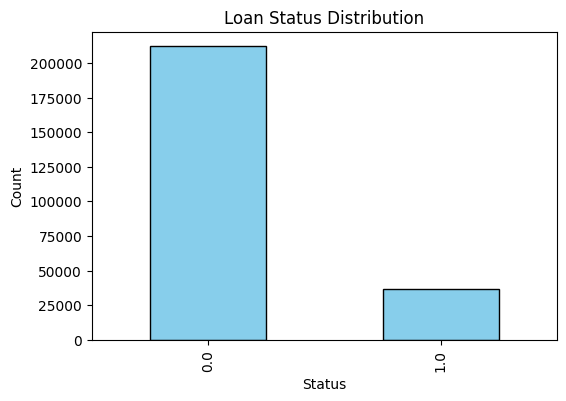

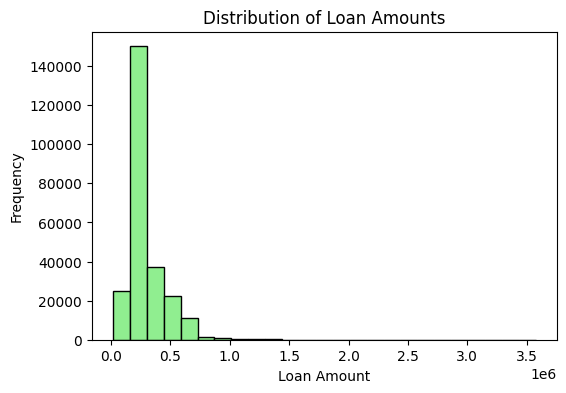

In [11]:
plt.figure(figsize=(6,4))
data['Status'].value_counts().plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Loan Status Distribution')
plt.xlabel('Status')
plt.ylabel('Count')
plt.show()

plt.figure(figsize=(6,4))
plt.hist(data['loan_amount'].dropna(), bins=25, color='lightgreen', edgecolor='black')
plt.title('Distribution of Loan Amounts')
plt.xlabel('Loan Amount')
plt.ylabel('Frequency')
plt.show()




## 6. Train–Test Split & Feature Scaling  

In [12]:
target_column = 'Status'
X = loan_df.drop(columns=[target_column])
y = loan_df[target_column]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

cat_cols = X_train.select_dtypes(include=['object', 'category']).columns.tolist()
num_cols = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()

encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
encoder.fit(X_train[cat_cols])

X_train_encoded = pd.DataFrame(encoder.transform(X_train[cat_cols]),
                               columns=encoder.get_feature_names_out(cat_cols),
                               index=X_train.index)
X_test_encoded = pd.DataFrame(encoder.transform(X_test[cat_cols]),
                              columns=encoder.get_feature_names_out(cat_cols),
                              index=X_test.index)

X_train_final = pd.concat([X_train[num_cols].reset_index(drop=True), X_train_encoded.reset_index(drop=True)], axis=1)
X_test_final = pd.concat([X_test[num_cols].reset_index(drop=True), X_test_encoded.reset_index(drop=True)], axis=1)

# 🧹 Clean feature names for XGBoost
X_train_final.columns = [col.replace('[', '_').replace(']', '_').replace('<', '_') for col in X_train_final.columns]
X_test_final.columns = [col.replace('[', '_').replace(']', '_').replace('<', '_') for col in X_test_final.columns]

# Ensure all names are strings
X_train_final.columns = X_train_final.columns.astype(str)
X_test_final.columns = X_test_final.columns.astype(str)

if list(X_train_final.columns) == list(X_test_final.columns):
    print("\n✅ Column consistency check passed! Columns match between train and test sets.")
else:
    print("\n⚠️ Column mismatch detected!")
    print("Missing in Test:", set(X_train_final.columns) - set(X_test_final.columns))
    print("Missing in Train:", set(X_test_final.columns) - set(X_train_final.columns))

scaler = StandardScaler()
X_train_final[num_cols] = scaler.fit_transform(X_train_final[num_cols])
X_test_final[num_cols] = scaler.transform(X_test_final[num_cols])

print("\n✅ StandardScaler applied to numerical features successfully!")
print("\nEncoded train shape:", X_train_final.shape)
print("Encoded test shape:", X_test_final.shape)

print("\n🔍 Before Encoding (sample):")
print(X.head(2))
print("\n🔍 After Encoding & Scaling (Train sample):")
print(X_train_final.head(2))

print("Before Scaling:\n", X_train[num_cols].head())
print("\nAfter Scaling (Train):\n", X_train_final[num_cols].head())


✅ Column consistency check passed! Columns match between train and test sets.

✅ StandardScaler applied to numerical features successfully!

Encoded train shape: (118936, 77)
Encoded test shape: (29734, 77)

🔍 Before Encoding (sample):
      ID  year loan_limit             Gender approv_in_adv loan_type  \
0  24890  2019         cf  Sex Not Available         nopre     type1   
1  24891  2019         cf               Male         nopre     type2   

  loan_purpose Credit_Worthiness open_credit business_or_commercial  ...  \
0           p1                l1        nopc                  nob/c  ...   
1           p1                l1        nopc                    b/c  ...   

   income  credit_type  Credit_Score  co-applicant_credit_type    age  \
0  1740.0          EXP           758                       CIB  25-34   
1  4980.0         EQUI           552                       EXP  55-64   

  submission_of_application        LTV Region  Security_Type dtir1  
0                   to_inst 

In [13]:
# --------------------------------
# 🔸 Step 6.6: Handle Any Remaining Missing Values
# --------------------------------
print("\nChecking for missing values after encoding & scaling...")

missing_train = X_train_final.isnull().sum().sum()
missing_test = X_test_final.isnull().sum().sum()

print(f"Missing values in training data: {missing_train}")
print(f"Missing values in testing data: {missing_test}")

# Replace any NaNs with 0 (safe for scaled and encoded data)
if missing_train > 0 or missing_test > 0:
    X_train_final = X_train_final.fillna(0)
    X_test_final = X_test_final.fillna(0)
    print("✅ All missing values replaced with 0.")

else:
    print("✅ No missing values found in training or testing data.")



Checking for missing values after encoding & scaling...
Missing values in training data: 140830
Missing values in testing data: 35398
✅ All missing values replaced with 0.


In [14]:
X_train_final.to_csv("X_train_final.csv", index=False)
X_test_final.to_csv("X_test_final.csv", index=False)
y_train.to_csv("y_train.csv", index=False)
y_test.to_csv("y_test.csv", index=False)

In [15]:
from sklearn.feature_selection import SelectKBest, mutual_info_classif, RFE, SelectFromModel
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
trained_models = {}
model_results = []
feature_method = "from_rf"  # choose: kbest, rfe, from_rf, none

def select_kbest(X_train_final, y_train, X_test_final, k=40):
    selector = SelectKBest(mutual_info_classif, k=min(k, X_train_final.shape[1]))
    selector.fit(X_train_final, y_train)
    return selector.transform(X_train_final), selector.transform(X_test_final), selector

def select_rfe(X_train_final, y_train, X_test_final, n_features=40):
    base = LogisticRegression(max_iter=2000)
    rfe = RFE(base, n_features_to_select=min(n_features, X_train_final.shape[1]))
    rfe.fit(X_train_final, y_train)
    return rfe.transform(X_train_final), rfe.transform(X_test_final), rfe

def select_from_rf(X_train_final, y_train, X_test_final):
    rf = RandomForestClassifier(n_estimators=300)
    rf.fit(X_train_final, y_train)
    sfm = SelectFromModel(rf, threshold="median", prefit=True)
    return sfm.transform(X_train_final), sfm.transform(X_test_final), sfm

if feature_method == "kbest":
    Xtr_sel, Xte_sel, selector_obj = select_kbest(X_train_final, y_train, X_test_final)
elif feature_method == "rfe":
    Xtr_sel, Xte_sel, selector_obj = select_rfe(X_train_final, y_train, X_test_final)
elif feature_method == "from_rf":
    Xtr_sel, Xte_sel, selector_obj = select_from_rf(X_train_final, y_train, X_test_final)
else:
    Xtr_sel, Xte_sel = X_train_final.values, X_test_final.values
    selector_obj = None

print("Selected features:", Xtr_sel.shape)

Selected features: (118936, 39)


c:\Users\Purvi\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:2742: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
c:\Users\Purvi\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:2742: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


## 7. Model Training & Evaluation (Multiple Models)  

In [16]:
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, roc_auc_score, confusion_matrix

def get_metrics(y_true, y_pred, y_proba=None):
    cm = confusion_matrix(y_true, y_pred)
    if cm.shape == (2, 2):
        tn, fp, fn, tp = cm.ravel()
        specificity = tn / (tn + fp) if (tn + fp) > 0 else np.nan
    else:
        specificity = np.nan

    accuracy = accuracy_score(y_true, y_pred)
    sensitivity = recall_score(y_true, y_pred, zero_division=0)
    precision = precision_score(y_true, y_pred, zero_division=0)
    f1 = f1_score(y_true, y_pred, zero_division=0)
    auc = roc_auc_score(y_true, y_proba) if y_proba is not None else np.nan

    return accuracy, sensitivity, precision, specificity, f1, auc


Logistic Regression Model

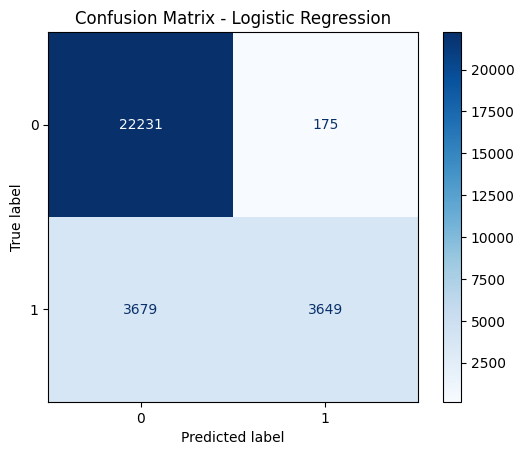

➡ Logistic Regression Accuracy: 0.8704


In [17]:
from sklearn.linear_model import LogisticRegression

model_name = "Logistic Regression"
log_reg = LogisticRegression(max_iter=1000)

# -----------------------------------
# 🔥 Train using FEATURE-SELECTED DATA
# -----------------------------------
log_reg.fit(Xtr_sel, y_train)

# Predictions
y_pred = log_reg.predict(Xte_sel)
y_proba = log_reg.predict_proba(Xte_sel)[:, 1]

# Metrics
acc, sens, prec, spec, f1, auc = get_metrics(y_test, y_pred, y_proba)

# Save results
model_results.append([1, model_name, acc, sens, prec, spec, f1, auc])

trained_models["Logistic Regression"] = log_reg
# -----------------------------------
# 🔵 Confusion Matrix with accuracy text
# -----------------------------------
disp = ConfusionMatrixDisplay.from_estimator(
    log_reg, Xte_sel, y_test, cmap="Blues", values_format='d'
)
plt.title(f"Confusion Matrix - {model_name}")
plt.show()

# Print accuracy below confusion matrix
print(f"➡ Logistic Regression Accuracy: {acc:.4f}")



Naive Bayes Model

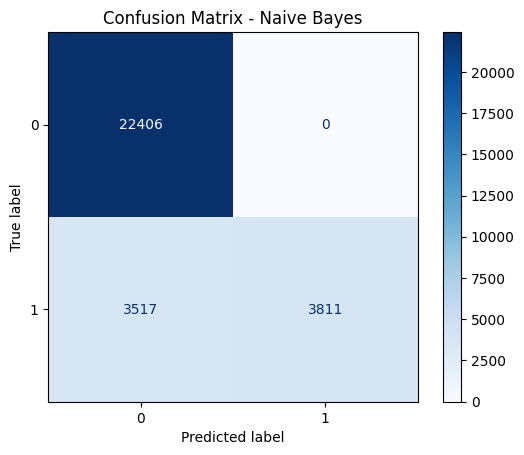

➡ Naive Bayes Accuracy: 0.8817


In [18]:
from sklearn.naive_bayes import GaussianNB

model_name = "Naive Bayes"
nb_model = GaussianNB()
nb_model.fit(Xtr_sel, y_train)
y_pred = nb_model.predict(Xte_sel)
y_proba = nb_model.predict_proba(Xte_sel)[:, 1]


acc, sens, prec, spec, f1, auc = get_metrics(y_test, y_pred, y_proba)
model_results.append([3, model_name, acc, sens, prec, spec, f1, auc])
trained_models["Naive Bayes"] = nb_model

disp = ConfusionMatrixDisplay.from_estimator(
    nb_model, Xte_sel, y_test, cmap="Blues", values_format='d'
)
plt.title(f"Confusion Matrix - {model_name}")
plt.show()

print(f"➡ Naive Bayes Accuracy: {acc:.4f}")

Decision Tree

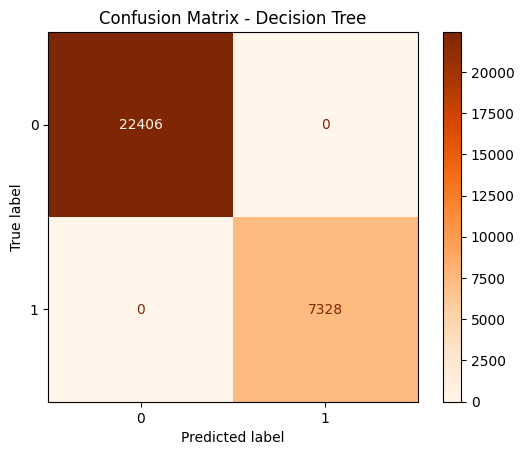

➡ Decision Tree Accuracy: 1.0000


In [19]:
from sklearn.tree import DecisionTreeClassifier

model_name = "Decision Tree"
dt_model = DecisionTreeClassifier(random_state=42)
dt_model.fit(Xtr_sel, y_train)
y_pred = dt_model.predict(Xte_sel)
y_proba = dt_model.predict_proba(Xte_sel)[:, 1]


acc, sens, prec, spec, f1, auc = get_metrics(y_test, y_pred, y_proba)
model_results.append([4, model_name, acc, sens, prec, spec, f1, auc])
trained_models["Decision Tree"] = dt_model

ConfusionMatrixDisplay.from_estimator(dt_model, Xte_sel, y_test, cmap="Oranges", values_format='d')
plt.title(f"Confusion Matrix - {model_name}")
plt.show()
print(f"➡ Decision Tree Accuracy: {acc:.4f}")

Random Forest

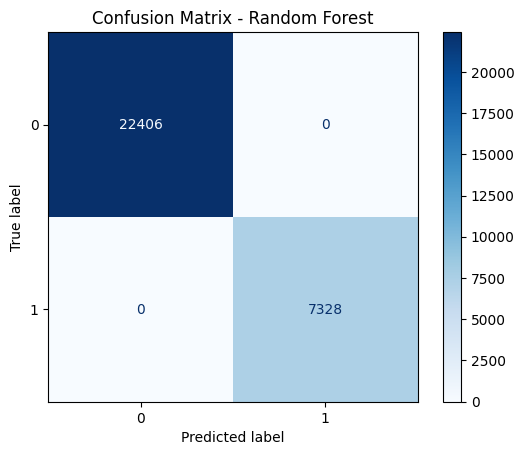

➡ Random Forest Accuracy: 1.0000


In [20]:
from sklearn.ensemble import RandomForestClassifier

model_name = "Random Forest"
rf_model = RandomForestClassifier(n_estimators=200, random_state=42, class_weight='balanced')
rf_model.fit(Xtr_sel, y_train)
y_pred = rf_model.predict(Xte_sel)
y_proba = rf_model.predict_proba(Xte_sel)[:, 1]

acc, sens, prec, spec, f1, auc = get_metrics(y_test, y_pred, y_proba)
model_results.append([5, model_name, acc, sens, prec, spec, f1, auc])
trained_models["Random Forest"] = rf_model
ConfusionMatrixDisplay.from_estimator(rf_model, Xte_sel, y_test, cmap="Blues", values_format='d')
plt.title(f"Confusion Matrix - {model_name}")
plt.show()
print(f"➡ Random Forest Accuracy: {acc:.4f}")

XGBoost

c:\Users\Purvi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\training.py:199: UserWarning: [20:29:25] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


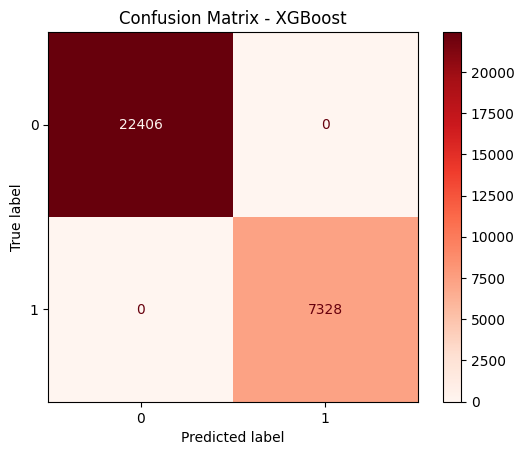

➡ XGBoost Accuracy: 1.0000


In [ ]:

from xgboost import XGBClassifier

model_name = "XGBoost"
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb_model.fit(Xtr_sel, y_train)
y_pred = xgb_model.predict(Xte_sel)
y_proba = xgb_model.predict_proba(Xte_sel)[:, 1]

acc, sens, prec, spec, f1, auc = get_metrics(y_test, y_pred, y_proba)
model_results.append([6, model_name, acc, sens, prec, spec, f1, auc])
trained_models["XGBoost"] = xgb_model
ConfusionMatrixDisplay.from_estimator(xgb_model, Xte_sel, y_test, cmap="Reds", values_format='d')
plt.title(f"Confusion Matrix - {model_name}")
plt.show()

print(f"➡ XGBoost Accuracy: {acc:.4f}")

svm model

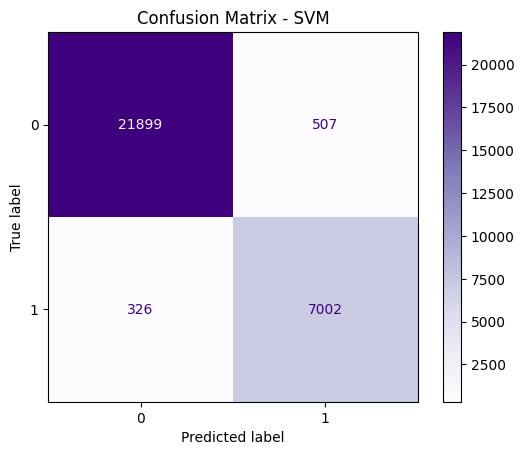

➡ SVM Accuracy: 0.9720


In [22]:
from sklearn.svm import SVC

model_name = "SVM"
svm_model = SVC(probability=True)
svm_model.fit(Xtr_sel, y_train)
y_pred = svm_model.predict(Xte_sel)
y_proba = svm_model.predict_proba(Xte_sel)[:, 1]

acc, sens, prec, spec, f1, auc = get_metrics(y_test, y_pred, y_proba)
model_results.append([2, model_name, acc, sens, prec, spec, f1, auc])
trained_models["SVM"] = svm_model
ConfusionMatrixDisplay.from_estimator(svm_model, Xte_sel, y_test, cmap="Purples", values_format='d')
plt.title(f"Confusion Matrix - {model_name}")
plt.show()
print(f"➡ SVM Accuracy: {acc:.4f}")

In [23]:
columns = ["S.No", "Model", "Accuracy", "Sensitivity", "Precision", "Specificity", "F1-Score", "AUC"]
results_df = pd.DataFrame(model_results, columns=columns)

print("\n--- MODEL PERFORMANCE SUMMARY ---")
print(results_df)

# Save to CSV
results_df.to_csv("model_performance_summary.csv", index=False)


--- MODEL PERFORMANCE SUMMARY ---
   S.No                Model  Accuracy  Sensitivity  Precision  Specificity  \
0     1  Logistic Regression  0.870384     0.497953   0.954236     0.992190   
1     3          Naive Bayes  0.881718     0.520060   1.000000     1.000000   
2     4        Decision Tree  1.000000     1.000000   1.000000     1.000000   
3     5        Random Forest  1.000000     1.000000   1.000000     1.000000   
4     6              XGBoost  1.000000     1.000000   1.000000     1.000000   
5     2                  SVM  0.971985     0.955513   0.932481     0.977372   

   F1-Score       AUC  
0  0.654412  0.838493  
1  0.684263  1.000000  
2  1.000000  1.000000  
3  1.000000  1.000000  
4  1.000000  1.000000  
5  0.943857  0.996413  


C:\Users\Purvi\AppData\Local\Temp\ipykernel_11900\3750854076.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=results_df, x="Model", y="Accuracy", palette="viridis")


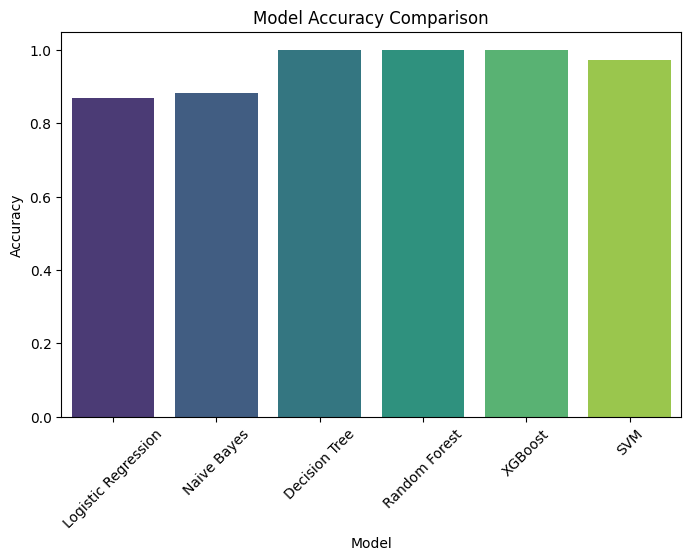

In [24]:
plt.figure(figsize=(8, 5))
sns.barplot(data=results_df, x="Model", y="Accuracy", palette="viridis")
plt.title("Model Accuracy Comparison")
plt.xticks(rotation=45)
plt.show()


Training MLP with activation = relu


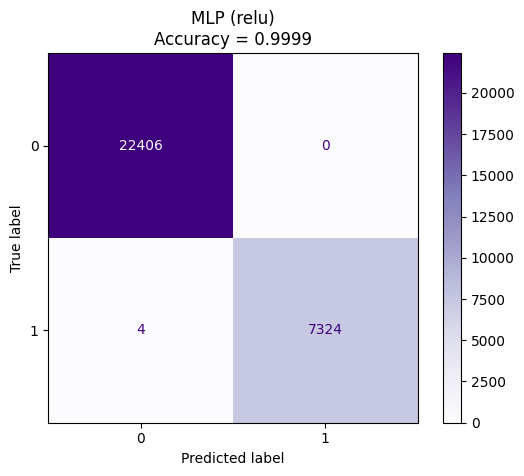


Training MLP with activation = tanh


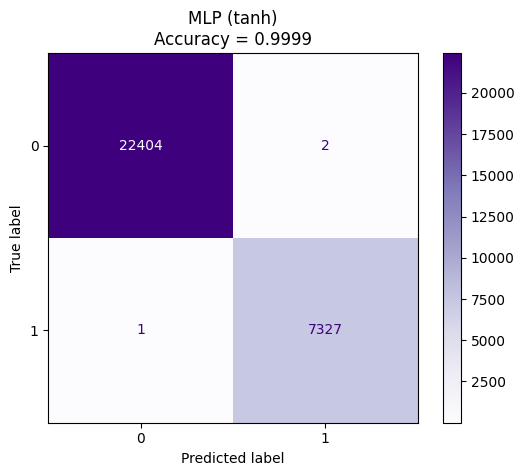


Training MLP with activation = logistic


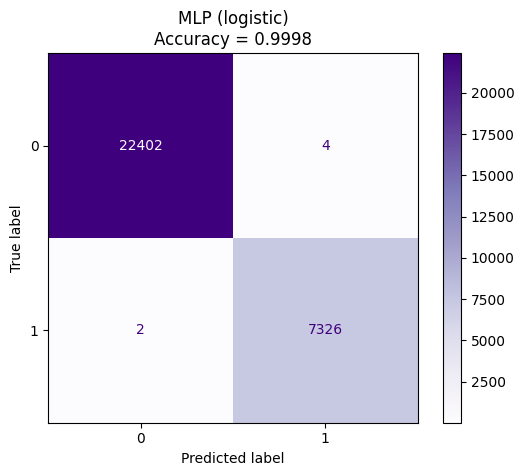

,Activation,Accuracy,Sensitivity,Precision,Specificity,F1-Score,AUC
0,relu,0.999865,0.999454,1.000000,1.000000,0.999727,0.999884
1,tanh,0.999899,0.999864,0.999727,0.999911,0.999795,1.000000
2,logistic,0.999798,0.999727,0.999454,0.999821,0.999591,0.999980


In [25]:
# ------------------------------
# STEP 8 — MLP Neural Network With Different Activations (New)
# ------------------------------

from sklearn.neural_network import MLPClassifier

activations = ["relu", "tanh", "logistic"]
mlp_results = []

for act in activations:
    print(f"\nTraining MLP with activation = {act}")
    mlp = MLPClassifier(hidden_layer_sizes=(100,), activation=act, max_iter=500)
    mlp.fit(Xtr_sel, y_train)
    
    y_pred = mlp.predict(Xte_sel)
    acc = accuracy_score(y_test, y_pred)

    ConfusionMatrixDisplay.from_predictions(y_test, y_pred, cmap="Purples")
    plt.title(f"MLP ({act})\nAccuracy = {acc:.4f}")
    plt.show()

    if hasattr(mlp, "predict_proba"):
        y_proba = mlp.predict_proba(Xte_sel)[:,1]
    else:
        y_proba = None

    acc, sens, prec, spec, f1, auc = get_metrics(y_test, y_pred, y_proba)
    mlp_results.append([act, acc, sens, prec, spec, f1, auc])

pd.DataFrame(mlp_results,
    columns=["Activation","Accuracy","Sensitivity","Precision","Specificity","F1-Score","AUC"])


In [27]:
# ------------------------------
# STEP 9 — Mathematical Equations (New)
# ------------------------------

# Logistic Regression equation
lr = trained_models["Logistic Regression"]
coefs = lr.coef_.flatten()
intercept = lr.intercept_[0]

print("\nLogistic Regression Decision Equation:")
print("z(x) = Σ (w_i * x_i) + b")
print("Probability = 1 / (1 + exp(-z(x)))")

# SVM Linear decision function
svm = trained_models["SVM"]
print("\nSVM Decision Function:")
print("f(x) = w^T x + b")
print("Prediction = sign(f(x))")
print("Margin = 2 / ||w||")

# RF feature importance
rf = trained_models["Random Forest"]
importances = rf.feature_importances_
print("\nRandom Forest Top Features:")
print(pd.Series(importances).sort_values(ascending=False).head())



Logistic Regression Decision Equation:
z(x) = Σ (w_i * x_i) + b
Probability = 1 / (1 + exp(-z(x)))

SVM Decision Function:
f(x) = w^T x + b
Prediction = sign(f(x))
Margin = 2 / ||w||

Random Forest Top Features:
2     0.304697
4     0.280212
3     0.244322
31    0.070211
6     0.019914
dtype: float64


In [28]:
# ------------------------------
# STEP 10 — Save Custom PurviModel (New)
# ------------------------------

best_model_name = results_df.loc[results_df["Accuracy"].idxmax(), "Model"]
best_model = trained_models[best_model_name]

purvi_payload = {
    "selector": selector_obj,
    "model": best_model,
    "features": Xtr_sel.shape[1]
}

import joblib
joblib.dump(purvi_payload, "PurviModel.joblib")

print("PurviModel saved successfully!")
print("Model chosen:", best_model_name)


PurviModel saved successfully!
Model chosen: Decision Tree


In [30]:
# --------------------------------
# 🔹 Step 10: Evaluate Models on Test Data (Corrected)
# --------------------------------

testing_results = []

for i, (name, model) in enumerate(trained_models.items(), start=1):
    try:
        # Use selected-test features (NOT full test dataset)
        y_pred = model.predict(Xte_sel)

        if hasattr(model, "predict_proba"):
            y_proba = model.predict_proba(Xte_sel)[:, 1]
        else:
            y_proba = None

        acc, sens, prec, spec, f1, auc = get_metrics(y_test, y_pred, y_proba)
        testing_results.append([i, name, acc, sens, prec, spec, f1, auc])

        print(f"✅ Evaluated (Corrected): {name}")

    except Exception as e:
        print(f"⚠️ Error evaluating {name}: {e}")

testing_df = pd.DataFrame(
    testing_results,
    columns=["S.No", "Model", "Accuracy", "Sensitivity", "Precision", "Specificity", "F1-Score", "AUC"]
)

print("\n--- TESTING PERFORMANCE SUMMARY (CORRECTED) ---")
print(testing_df)


✅ Evaluated (Corrected): Logistic Regression
✅ Evaluated (Corrected): Naive Bayes
✅ Evaluated (Corrected): Decision Tree
✅ Evaluated (Corrected): Random Forest
✅ Evaluated (Corrected): XGBoost
✅ Evaluated (Corrected): Linear SVM 

--- TESTING PERFORMANCE SUMMARY (CORRECTED) ---
   S.No                Model  Accuracy  Sensitivity  Precision  Specificity  \
0     1  Logistic Regression  0.870384     0.497953   0.954236     0.992190   
1     2          Naive Bayes  0.881718     0.520060   1.000000     1.000000   
2     3        Decision Tree  1.000000     1.000000   1.000000     1.000000   
3     4        Random Forest  1.000000     1.000000   1.000000     1.000000   
4     5              XGBoost  1.000000     1.000000   1.000000     1.000000   
5     6          Linear SVM   0.971985     0.955513   0.932481     0.977372   

   F1-Score       AUC  
0  0.654412  0.838493  
1  0.684263  1.000000  
2  1.000000  1.000000  
3  1.000000  1.000000  
4  1.000000  1.000000  
5  0.943857  0.996413  

In [31]:
# Merge both tables on Model name
final_comparison = pd.merge(
    results_df,
    testing_df,
    on="Model",
    suffixes=("_Train", "_Test")
)

# Reorder columns neatly
cols = [
    "S.No_Train", "Model",
    "Accuracy_Train", "Accuracy_Test",
    "F1-Score_Train", "F1-Score_Test",
    "AUC_Train", "AUC_Test",
    "Sensitivity_Train", "Sensitivity_Test",
    "Specificity_Train", "Specificity_Test",
    "Precision_Train", "Precision_Test"
]
final_comparison = final_comparison[cols]

print("\n--- FINAL COMBINED TRAINING & TESTING PERFORMANCE ---")
print(final_comparison)

# Save to CSV
final_comparison.to_csv("final_model_comparison.csv", index=False)
print("\n💾 Combined performance table saved as 'final_model_comparison.csv'")



--- FINAL COMBINED TRAINING & TESTING PERFORMANCE ---
   S.No_Train                Model  Accuracy_Train  Accuracy_Test  \
0           1  Logistic Regression        0.870384       0.870384   
1           3          Naive Bayes        0.881718       0.881718   
2           4        Decision Tree        1.000000       1.000000   
3           5        Random Forest        1.000000       1.000000   
4           6              XGBoost        1.000000       1.000000   

   F1-Score_Train  F1-Score_Test  AUC_Train  AUC_Test  Sensitivity_Train  \
0        0.654412       0.654412   0.838493  0.838493           0.497953   
1        0.684263       0.684263   1.000000  1.000000           0.520060   
2        1.000000       1.000000   1.000000  1.000000           1.000000   
3        1.000000       1.000000   1.000000  1.000000           1.000000   
4        1.000000       1.000000   1.000000  1.000000           1.000000   

   Sensitivity_Test  Specificity_Train  Specificity_Test  Precision_Train

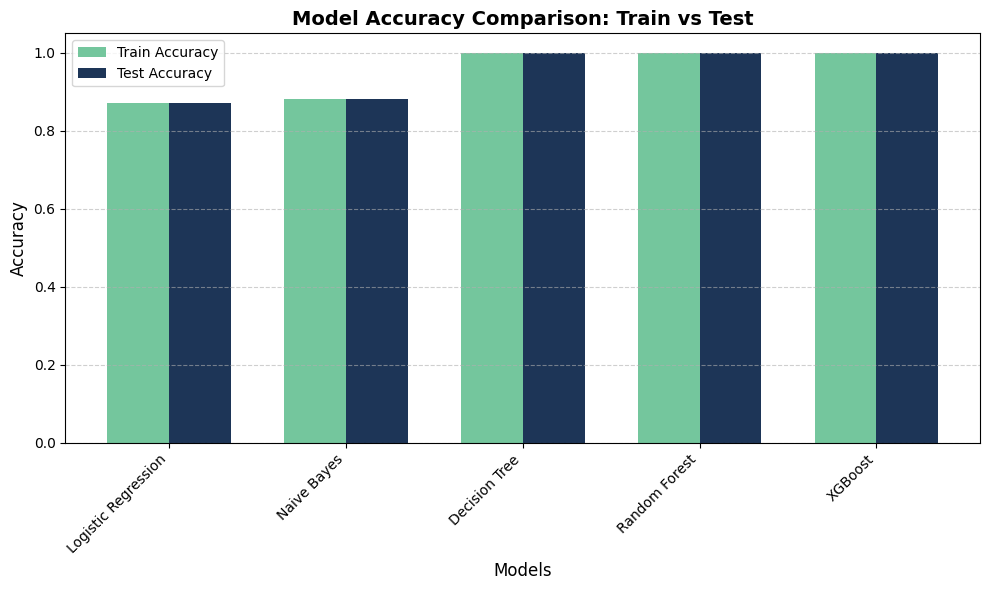

In [32]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# ---------------------------------------
# ✅ Train vs Test Accuracy Comparison Plot
# ---------------------------------------

plt.figure(figsize=(10, 6))

# Calculate bar width and x locations
x = np.arange(len(final_comparison["Model"]))
width = 0.35

plt.bar(x - width/2, final_comparison["Accuracy_Train"], width, label='Train Accuracy', color='#74c69d')
plt.bar(x + width/2, final_comparison["Accuracy_Test"], width, label='Test Accuracy', color='#1d3557')

plt.xlabel("Models", fontsize=12)
plt.ylabel("Accuracy", fontsize=12)
plt.title("Model Accuracy Comparison: Train vs Test", fontsize=14, fontweight='bold')
plt.xticks(x, final_comparison["Model"], rotation=45, ha='right')

plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()
